In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import json

with open('/content/drive/My Drive/deep_proj/images_info.json') as json_file:
    images_info = json.load(json_file)
with open('/content/drive/My Drive/deep_proj/captions.json') as json_file:
    captions = json.load(json_file)

In [0]:
#sort by id
images_info_sorted = sorted(images_info, key=lambda k: k.get('id', 0))
captions_sorted = sorted(captions, key=lambda k: k.get('image_id', 0))

In [0]:
!pip install pygame

In [0]:
import io, pygame
import zipfile
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re

image_number=5000
data_set=np.zeros([image_number,224,224,3],dtype='uint8')
file_path='/content/drive/My Drive/deep_proj/images.zip'

captions=[]
archive = zipfile.ZipFile(file_path, 'r')
ind=0
max_length=0
for index in range(image_number):
    imgdata = archive.read('val2017/'+images_info_sorted[index]['file_name'])
    if index % 500 ==0:
        print('data read: ',index)
    caption_list=set()
    for ind in range(len(captions_sorted)):
        if images_info_sorted[index]['id'] == captions_sorted[ind]['image_id']:
            temp = captions_sorted[ind]['caption']
            temp = [re.sub(r"[^a-zA-Z']+", ' ', k) for k in temp.split("\n")][0]
            if len(temp.split())>max_length:
                max_length=len(temp.split())
            caption_list.add(str.lower(temp))
    captions.append(list(caption_list))

    # create a pygame-compatible file-like object from the bytes
    bytes_io = io.BytesIO(imgdata)
    img = pygame.image.load(bytes_io)
    imgg = pygame.surfarray.array3d(img)
    final=imgg.swapaxes(0,1)
    resized = cv2.resize(final, (224,224), interpolation = cv2.INTER_AREA)
    data_set[index,:,:,:] = resized

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
data read:  0
data read:  500
data read:  1000
data read:  1500
data read:  2000
data read:  2500
data read:  3000
data read:  3500
data read:  4000
data read:  4500


['a plate of food which includes onions tomato lettuce sauce fries and a sandwich ', 'a sandwich french fries bowl of ketchup onion slice lettuce slice tomato slice and knife sit on the white plate ', 'a sandwich on a sesame seed bun next to a pile of french fries and a cup of ketchup ', 'partially eaten hamburger on a plate with fries and condiments ', 'a grilled chicken sandwich sits beside french fries made with real potatoes ']
max_length 49


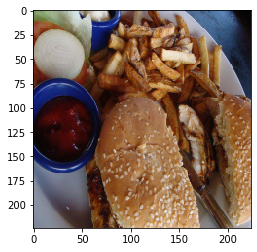

In [0]:
import matplotlib.pyplot as plt
import numpy as np
ni=100
plt.imshow(data_set[ni])
print(captions[ni])
print("max_length",max_length)

In [0]:
padding='<pad>'
start_seq='<start>'
end_seq='<end>'
new_captions=[]
image_idx_vec=[]
for i in range(len(captions)):
    temp_caption=[]
    for j in range(len(captions[i])):
        tem=start_seq+' '+ captions[i][j]+' '+end_seq+(' '+padding)*(max_length-len(captions[i][j].split()))
        # temp_caption.append(tem)
        new_captions.append(tem)
        image_idx_vec.append(i)
image_idx_vec=np.array(image_idx_vec)

In [0]:
len(new_captions)

25003

In [0]:
uniqe_words=set()
for i in range(len(new_captions)):
    for j in new_captions[i].split():
        uniqe_words.add(j)
number_of_unique_words=len(uniqe_words)
print('number of unique words: ',number_of_unique_words)

number of unique words:  7215


In [0]:
import keras
tokenizer = keras.preprocessing.text.Tokenizer(num_words=number_of_unique_words,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(new_captions)
train_seqs = tokenizer.texts_to_sequences(new_captions)
train_seqs = np.array(train_seqs)

Using TensorFlow backend.


In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
print(train_seqs[0])
print(new_captions[0])

[  4   3  47  10 297   3  26  11   3  24   9  29   5   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2]
<start> a room with chairs a table and a woman in it  <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2
#Load the Resnet model
image_size=224
mobnet = MobileNetV2(weights='imagenet', include_top=True, input_shape=(image_size, image_size, 3))
# Freeze the layers except the last 4 layers
# for layer in resnet.layers[:-2]:
#     layer.trainable = False

In [0]:
mobnet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
from keras.models import Model
# resnet.summary()
transfer_layer = mobnet.get_layer('global_average_pooling2d_1')
image_model_transfer = Model(inputs=mobnet.input,
                             outputs=transfer_layer.output)

In [0]:
from keras import backend as K
transfer_values_size = K.int_shape(transfer_layer.output)[1]
print('feature vec. size: ',transfer_values_size)

feature vec. size:  1280


In [0]:
data_set = keras.applications.mobilenet_v2.preprocess_input(data_set)


In [0]:
feature_vec=image_model_transfer.predict(data_set)

In [0]:
print(feature_vec.shape)

(5000, 1280)


In [0]:
from keras.layers import Input, Dense, Embedding, GRU
from keras.models import Model
from keras import losses
state_size = 512
embedding_size = 128
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')


decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

decoder_input = Input(shape=(None, ), name='decoder_input')

decoder_embedding = Embedding(input_dim=number_of_unique_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)


decoder_dense = Dense(number_of_unique_words,
                      activation='linear',
                      name='decoder_output')

In [0]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [0]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [0]:
import tensorflow as tf
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [0]:
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=1e-3)

In [0]:
decoder_target = tf.placeholder(dtype='int32', shape=(None))


In [0]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

In [0]:
def batch_generator(batch_size):

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(len(image_idx_vec),
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = feature_vec[image_idx_vec[idx]]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens_padded = train_seqs[idx]

        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [0]:
generator=batch_generator(64)

In [0]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=256,
                            epochs=50,)

Epoch 1/50
256/256 [==============================] - 42s 162ms/step - loss: 0.2781
Epoch 2/50
256/256 [==============================] - 42s 163ms/step - loss: 0.2663
Epoch 3/50
256/256 [==============================] - 41s 161ms/step - loss: 0.2558
Epoch 4/50
256/256 [==============================] - 42s 162ms/step - loss: 0.2482
Epoch 5/50
256/256 [==============================] - 41s 159ms/step - loss: 0.2372
Epoch 6/50
256/256 [==============================] - 41s 159ms/step - loss: 0.2295
Epoch 7/50
256/256 [==============================] - 40s 156ms/step - loss: 0.2232
Epoch 8/50
256/256 [==============================] - 40s 156ms/step - loss: 0.2149
Epoch 9/50
256/256 [==============================] - 40s 157ms/step - loss: 0.2097
Epoch 10/50
256/256 [==============================] - 39s 154ms/step - loss: 0.2018
Epoch 11/50
256/256 [==============================] - 40s 156ms/step - loss: 0.1946
Epoch 12/50
256/256 [==============================] - 41s 161ms/step - lo

In [0]:
def generate_caption(im_idx, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = data_set[im_idx]
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token 
    token_int = tokenizer.word_index['<start>']

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token 
    # and we haven't processed the max number of tokens.
    while token_int != tokenizer.word_index['<end>'] and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.index_word[token_int]

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


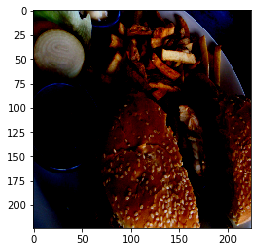

Predicted caption:
 a plate of some food with out two drink with a side city side <end>



In [0]:
generate_caption(100)

In [0]:
decoder_model.save('drive/My Drive/deep_proj/decoder_model.h5')
image_model_transfer.save('drive/My Drive/deep_proj/image_model_transfer.h5')


In [0]:
## Saving the model to Jason
from keras.models import model_from_json
# serialize model to JSON
model_json = decoder_model.to_json()
with open("drive/My Drive/deep_proj/decoder_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
decoder_model.save_weights("drive/My Drive/deep_proj/decoder_model.h5")
print("Saved model to drive")

Saved model to drive


In [0]:
import pickle

# saving tokenizer
with open('drive/My Drive/deep_proj/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

